In [1]:
import pandas as pd 
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from livelossplot import PlotLossesKeras
from tensorflow.keras.regularizers import l2



In [2]:
img_data = glob('Data/breast-histopathology-images/**/*.png', recursive=True)

In [3]:
img_data[:3]

['Data/breast-histopathology-images - Copy\\10253\\0\\10253_idx5_x1001_y1001_class0.png',
 'Data/breast-histopathology-images - Copy\\10253\\0\\10253_idx5_x1001_y1051_class0.png',
 'Data/breast-histopathology-images - Copy\\10253\\0\\10253_idx5_x1001_y1101_class0.png']

In [4]:
#images with cancer ends with {0.png} and images without cancer ends with {1.png}
cancer_img = []
no_cancer_img = []

for i in img_data:
    if   i[-5] == '1': 
        no_cancer_img.append(i)
    elif i[-5] == '0':
        cancer_img.append(i)

In [5]:
#count the number of cancer images and non cancer images 

count_cancer_image = len(cancer_img)
count_no_cancer_image = len(no_cancer_img)

total_images = count_cancer_image + count_no_cancer_image

cancer_percentage = (count_cancer_image / total_images) * 100
no_cancer_percentage = (count_no_cancer_image / total_images) * 100

print(f"Number of cancer images: {count_cancer_image} (Percentage: {round(cancer_percentage, 2)}%)")
print(f"Number of non-cancer images: {count_no_cancer_image} (Percentage: {round(no_cancer_percentage, 2)}%)")
print("Total images:", total_images)

Number of cancer images: 31794 (Percentage: 74.32%)
Number of non-cancer images: 10987 (Percentage: 25.68%)
Total images: 42781


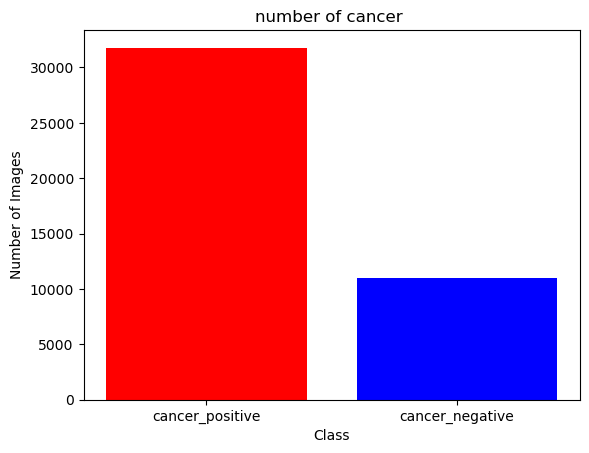

In [6]:
#make visualizations 
#Barchart 
labels = ['cancer_positive', 'cancer_negative']
values = [count_cancer_image, count_no_cancer_image]
plt.bar(labels, values, color=['red', 'blue'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('number of cancer ')
plt.show()

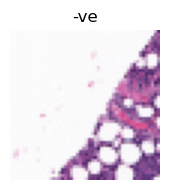

In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Create a single plot to show the cancer negative image

img = image.load_img(no_cancer_img[2], target_size=(50, 50)) #load image #3 and make the resolution of the image 100*100
img = image.img_to_array(img)

# Create a single plot to show the non-cancer image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.title('-ve')
plt.imshow(img.astype('uint8'))  # Use plt.imshow instead of plt.imgshow
plt.tight_layout()
plt.show()

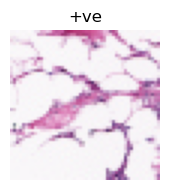

In [8]:
# Create a single plot to show the cancer positive image

img = image.load_img(cancer_img[2], target_size=(50, 50)) #load image #3 and make the resolution of the image 100*100
img = image.img_to_array(img)

plt.figure(figsize=(2, 2))
plt.axis('off')
plt.title('+ve')
plt.imshow(img.astype('uint8'))  
plt.tight_layout()
plt.show()

In [10]:
import cv2
import random

#shuffle images for reducing bias, creating randomization and reduce patterns 
random.shuffle(no_cancer_img)
random.shuffle(cancer_img)

image_size = (50, 50)

non_img_arr = []
for img_path in no_cancer_img:
    n_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, image_size, interpolation=cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])
    
can_img_arr = []
for img_path in cancer_img:
    c_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, image_size, interpolation=cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

In [11]:

breast_img_arr = non_img_arr[:10000] + can_img_arr[:10000]

np.random.shuffle(breast_img_arr) #shuffle for more randomization

X = np.array([item[0] for item in breast_img_arr])
y = np.array([item[1] for item in breast_img_arr])

In [12]:
X.shape

(20000, 50, 50, 3)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 


In [14]:
model = tf.keras.Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(50, 50, 3)),
    Dropout(0.25),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.25),
    MaxPooling2D(2, 2),
    
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.25),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics = ['Accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 dropout_1 (Dropout)         (None, 22, 22, 128)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 128)      0         
 2D)                                                    

In [15]:


lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='Accuracy', patience=3, verbose=1, factor=0.9, min_lr=1e-5)

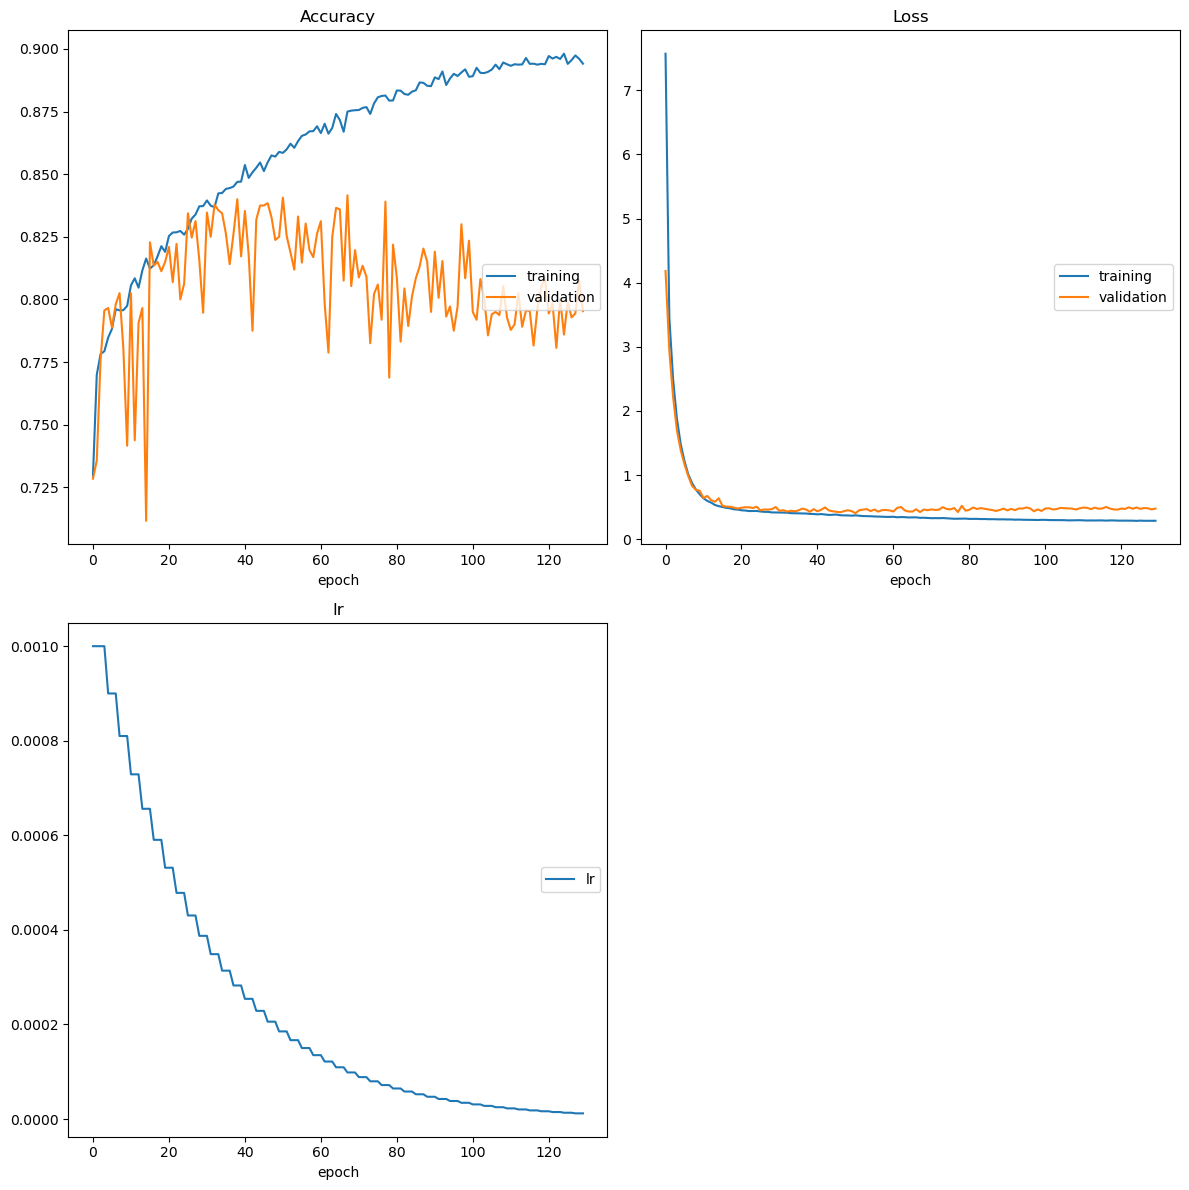

Accuracy
	training         	 (min:    0.730, max:    0.898, cur:    0.894)
	validation       	 (min:    0.712, max:    0.842, cur:    0.795)
Loss
	training         	 (min:    0.287, max:    7.569, cur:    0.289)
	validation       	 (min:    0.407, max:    4.182, cur:    0.479)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
366/366 [==============================] - 31s 85ms/step - loss: 0.2886 - Accuracy: 0.8941 - val_loss: 0.4791 - val_Accuracy: 0.7953 - lr: 1.1973e-05


In [ ]:
history = model.fit(X_train, y_train, 
                    validation_split= 0.2,
                    epochs = 130,
                    batch_size = 35, 
                    callbacks = [lr_decay, PlotLossesKeras()],
                    shuffle = True
                    )

In [27]:
from tensorflow import keras

from keras.models import load_model
model =  load_model('C:/Users/amer_/Documents/GitHub/Breast_Cancer_class/my_model.h5')

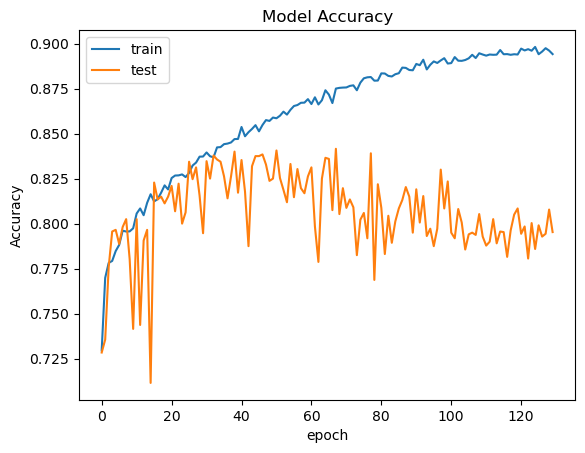

In [ ]:
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

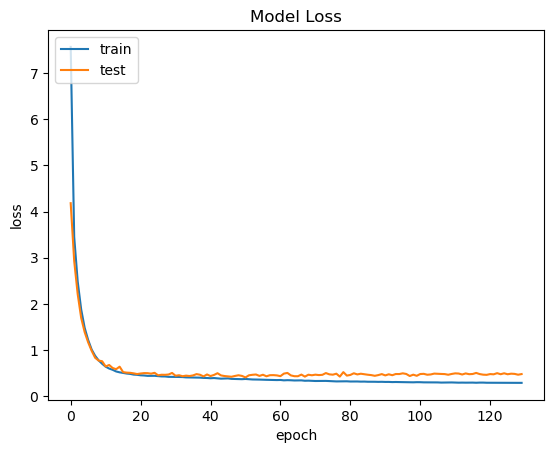

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [28]:
model.evaluate(X_test,y_test)

125/125 [==============================] - 2s 16ms/step - loss: 0.4522 - Accuracy: 0.8133


[0.4522063136100769, 0.8132500052452087]

125/125 [==============================] - 2s 14ms/step
[[0]
 [0]
 [1]
 ...
 [0]
 [1]
 [1]]


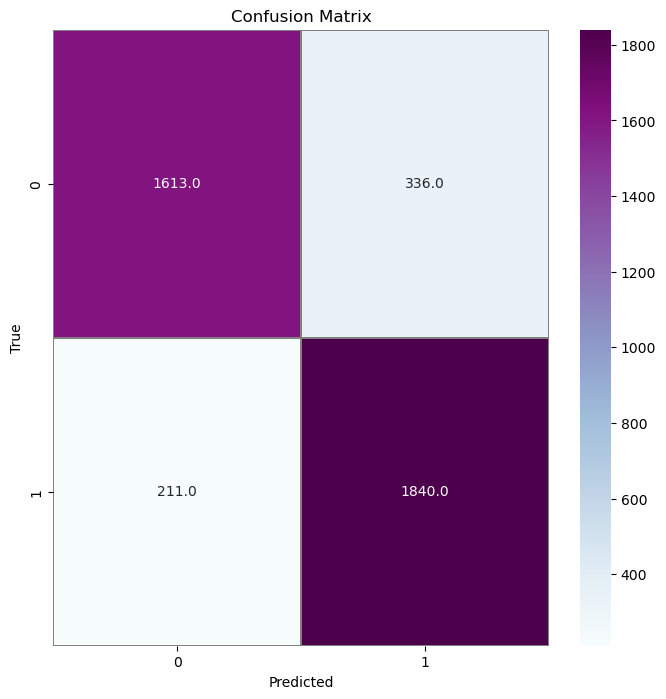

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
Y_pred = model.predict(X_test)

#the output is continous values, we need binary numbers for classifications
Y_pred_classes = np.where(Y_pred >= 0.2, 1, 0) #if Y_pred >= 0.2 then the condition is true 


print(Y_pred_classes)
Y_true = np.array(y_test)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [56]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print('Precision: %.3f' % precision_score(y_test, Y_pred_classes))

print('Recall: %.3f' % recall_score(y_test, Y_pred_classes))

Precision: 0.846
Recall: 0.897


In [57]:
prediction = model.predict(X_test)



125/125 [==============================] - 2s 14ms/step


In [58]:
prediction

array([[0.01256399],
       [0.0120796 ],
       [0.7914934 ],
       ...,
       [0.05633468],
       [0.55152774],
       [0.7001996 ]], dtype=float32)

In [59]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])


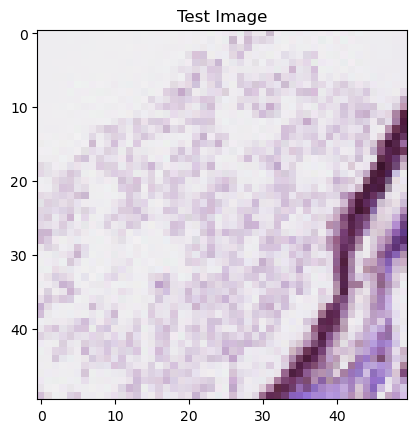

In [60]:
index = 100
img_plot(X_test, index)